# Table of Contents

1. [Data Cleaning, Preprocessing and Parametrization](#datacleaning)
2. [SIR on Network](#EoN)
    1. [Fixed Parameters](#fix)
    2. [Fixed Parameters with weights](#fixweight)
    3. [Introducing heterogeneity](#heterogeneity)
    4. [All countries scenarios](#all)



In [2]:
#importing necessary packages

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from scipy.integrate import odeint
import networkx as nx


# Data Cleaning, Preprocessing and Parametrization <a name="datacleaning"></a>

In the following cells we are going to import and pre-process our data. Plus, we will be computing the model parameters. Besides the Betas and Gammas mentioned in the paper, we also tried different weighted procedures using two further inputs: the Derivetives' exposure and the GDP of each country. The aim was to try different weighting procedures, yet we decided to stick to the definition of "ultimate financial risk" explained in the paper. Nevertheless, we kept our computation in this notebook.

The way we computed all the parameters and weights is the following:

- Beta coefficients:

$$β_i= \frac{α_{i}}{\sum_{j=1}^{23}α_{j}}$$

where $α_{ij}$ is the claims exposure of country i towards country j.

- Gamma coefficients:

$$ɣ_i= \frac{1}{101-C_i}$$

where $C_i$ is the numeric risk score attributed to that country: the higher the risk, the higher the recovery time from the crisis.

- Weighted Betas with derivatives

$$β_i= \frac{α_{i}}{\sum_{j=1}^{23}α_{ij}}*w_i$$

where $w_i$ is proportional to the derivative exposure of country i.


- Inverse score: once we computed the normalized weights from the GDP of each country, we computed the inverse score as follows:


$$score_i= \frac{1}{\sum_{j=1}^{23}w_j}$$

where $w_i$ is the normalized GDP ($w_i= \frac{GDP_i}{\sum_{j=1}^{23}GDP_j}$) of country i. The *ratio* is that the higher the GDP, the less risky the country is. Of course those scores are normalized before being used, so that they sum up to 1.

In [6]:
#run this cell to obtain the final dataset

df = pd.read_excel('data/table-b3-s.xlsx')[['Unnamed: 0', 'Foreign Claims', 'Derivatives']].rename(columns = {'Unnamed: 0': 'Country'}).iloc[0:24]
scores = pd.read_excel("data/new credit score.xlsx").rename(columns = {'Unnamed: 0': 'Country'})
countries = []
for i in range(len(scores)):
    countries.append(scores['Country'][i])
    
countries[countries.index('South Korea')] = 'Korea'
scores['Country']=countries

mask = [i in df['Country'].unique() for i in scores['Country']]
scores = scores[mask]

#removing Chinese Taipei from df since there is no corresponding scoring.
df=df.set_index('Country', drop=True)
df = df.drop('Chinese Taipei', axis=0)
assert len(df) == len(scores)
df=df.reset_index(drop=False)

final_df = df.merge(scores, how='inner', left_on='Country', right_on='Country')[['Country', 'Foreign Claims', 'Derivatives', 'Numeric Value']].set_index('Country', drop=True)


#len(countries)

#data cleaning, merging and preprocessing. Skip this cell and run to the next one to directly obtain the final dataset

df_w = pd.read_excel('data/API_NY.GDP.MKTP.CD_DS2_en_excel_v2_935893.xls')
ind = df_w.index[df_w['Country Name'] == 'Korea, Rep.']
df_w.at[ind[0], 'Country Name'] = 'Korea'
df_w=df_w.rename(columns={'GDP ': 'GDP'}).reset_index(drop=True)
df_w.head()

#picking only those 23 countries we are interested in
mask = [i in final_df.index for i in df_w['Country Name']]
df_w = df_w[mask]
df_w = df_w.reset_index(drop=True)



#computing weights

s = df_w['GDP'].sum()
w = []
for i in range(len(df_w)):
    w.append(df_w['GDP'][i]/s)
    
df_w['Weighted scores']=w
df_w = df_w.drop('Weighet score', axis = 1)

#computing inverse scores, since the higher the GDP, the less risky the country is

tmp = []
for i in range(len(df_w)):
    w = 1/df_w['Weighted scores'][i]
    tmp.append(w)
    
df_w['tmp'] = tmp

inv_w = []
s = sum(df_w['tmp'])
for i in range(len(df_w)):
    inv = df_w['tmp'][i]/s
    inv_w.append(inv)

df_w['Inverse score'] = inv_w
df_w = df_w.drop('tmp', axis = 1)

#sum(df_w['Inverse score']) to assert whether it sums up to 1


#merging the final_df with this df_w
df_w = df_w.merge(final_df, left_on = 'Country Name', 
           right_index=True).drop(['GDP', 'Weighted scores'], 
                                  axis = 1).rename(columns = {'Numeric Value': 'Credit Score'})


final_df = df_w.sort_values(by = 'Country Name', ascending = True).reset_index(drop=True)



#computing betas and gammas

betas = []
weighted_betas = [] #weighted by Derivatives
tot_claims = final_df['Foreign Claims'].sum()
tot_derivatives = final_df['Derivatives'].sum()

for i in range(len(final_df)):
      weight = final_df['Derivatives'][i]/tot_derivatives
      num = final_df['Foreign Claims'][i]
      betas.append(num/tot_claims)
      weighted_betas.append((num/tot_claims)*weight)
    
weighted_betas = [float(i)/sum(weighted_betas) for i in weighted_betas]
#sum(weighted_betas)==1.0

gammas = []
for i in range(len(final_df)):
    gammas.append(1/(101-final_df['Credit Score'][i]))
#gammas

final_df['betas'] = betas
final_df['gammas'] = gammas
final_df['weighted betas'] = weighted_betas


#storing results
final_df.to_pickle("final_df.pkl")

Foreign Claims  Derivatives  Numeric Value
Country                                              
Australia           687.6         55.5          100.0
Austria             391.2         20.4           95.0
Belgium             233.5         32.7           90.0
Canada             1897.9        115.3          100.0
Chile                14.2          2.6           80.0

In [3]:
#run this cell to download results
final_df = pd.read_pickle("final_df.pkl")
final_df

Country Name  Inverse score  Foreign Claims  Derivatives  Credit Score  \
0        Australia       0.019712           687.6         55.5         100.0   
1          Austria       0.062082           391.2         20.4          95.0   
2          Belgium       0.052077           233.5         32.7          90.0   
3           Canada       0.016497          1897.9        115.3         100.0   
4            Chile       0.094776            14.2          2.6          80.0   
5          Finland       0.102135           472.9         58.3          95.0   
6           France       0.010176          3098.6        146.5          90.0   
7          Germany       0.007160          1873.4        695.3         100.0   
8           Greece       0.129638            57.7          1.0          40.0   
9            India       0.010396            85.6         58.9          55.0   
10         Ireland       0.073898            92.8          4.6          85.0   
11           Italy       0.013564           851.6         85.1          60.0   
12           Japan       0.005686          4371.8         51.9          80.0   
13           Korea       0.017454           197.8          9.6          90.0   
14     Netherlands       0.030936          1327.1        198.1         100.0   
15        Portugal       0.117442            95.6          6.1          60.0   
16       Singapore       0.077618           567.6         24.5         100.0   
17           Spain       0.019919          1756.6        143.8          75.0   
18          Sweden       0.050829           346.5         28.4         100.0   
19     Switzerland       0.040085          1084.2        259.8         100.0   
20          Turkey       0.036644            25.9          4.8          35.0   
21  United Kingdom       0.009899          3605.7        489.2          90.0   
22   United States       0.001376          3599.6        225.9          95.0   

       betas    gammas  weighted betas  
0   0.025719  1.000000        0.006623  
1   0.014632  0.166667        0.001385  
2   0.008734  0.090909        0.001325  
3   0.070988  1.000000        0.037976  
4   0.000531  0.047619        0.000006  
5   0.017688  0.166667        0.004785  
6   0.115899  0.090909        0.078780  
7   0.070072  1.000000        0.226055  
8   0.002158  0.016393        0.000010  
9   0.003202  0.021739        0.000875  
10  0.003471  0.062500        0.000074  
11  0.031853  0.024390        0.012577  
12  0.163521  0.047619        0.039377  
13  0.007398  0.090909        0.000330  
14  0.049638  1.000000        0.045625  
15  0.003576  0.024390        0.000101  
16  0.021230  1.000000        0.002413  
17  0.065703  0.038462        0.043837  
18  0.012960  1.000000        0.001708  
19  0.040553  1.000000        0.048883  
20  0.000969  0.015152        0.000022  
21  0.134866  0.090909        0.306117  
22  0.134638  0.166667        0.141118

Let's inspect the interaction between gammas and betas: we are expecting high betas to correspond to low gammas and vice-versa.

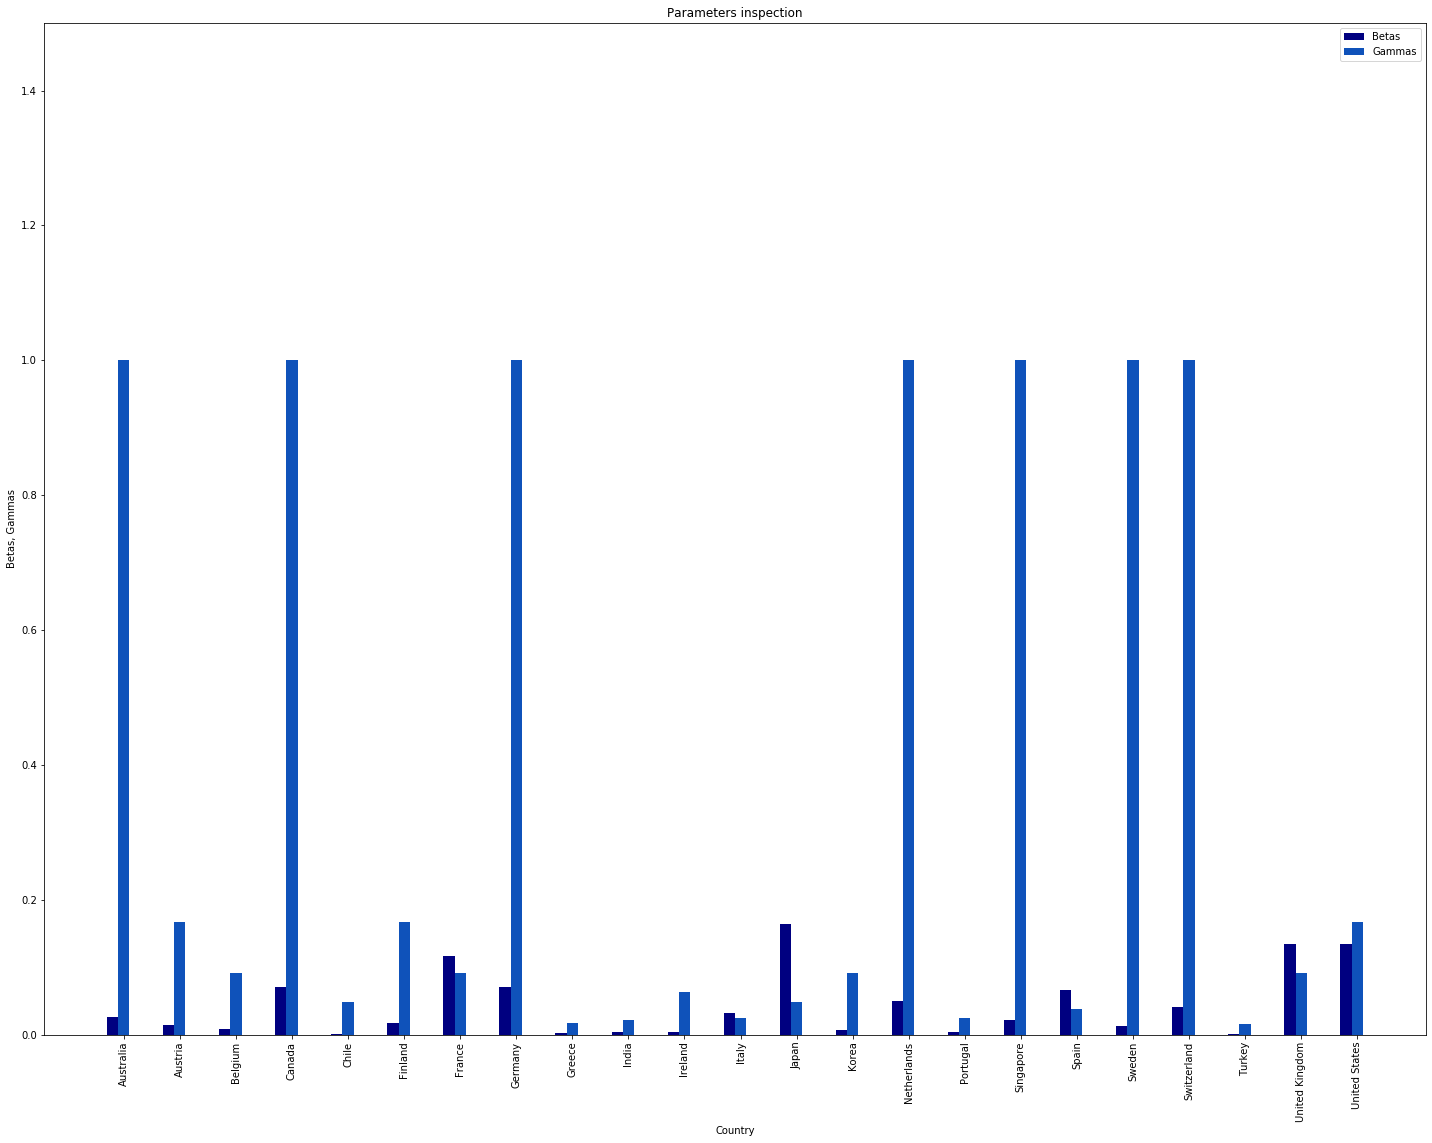

In [14]:
countries = [i for i in final_df['Country Name']]

import numpy as np
import matplotlib.pyplot as plt

data = np.zeros(len(countries)*2).reshape(len(countries), 2)
for i in range(len(final_df)):
    data[i][0] = final_df['betas'][i]
    data[i][1] = final_df['gammas'][i]
    



length = len(countries)
x_labels = countries

# Set plot parameters
fig = plt.figure(figsize=(20,15))
ax = plt.subplot(111)
width = 0.2 # width of bar
x = np.arange(length)

ax.bar(x, data[:,0], width, color='#000080', label='Betas')
ax.bar(x + width, data[:,1], width, color='#0F52BA', label='Gammas')


ax.set_ylabel('Betas, Gammas')
ax.set_ylim(0,1.5)
ax.set_xticks(x + width)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Country')
ax.set_title('Parameters inspection')
ax.legend()
#plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

fig.tight_layout()
plt.xticks(rotation='vertical')
plt.show()

# SIR on Network <a name="EoN"></a>

The idea is building a complete weighted graph where each node represents a country with edge weights proportional to the inverse GDP score. In the first experiment, we won't make use of those weights.

In [9]:
#run this cell to obtain the final dataset
import pandas as pd
import pickle
df = pd.read_pickle('final_df.pkl')
df


Country Name  Inverse score  Foreign Claims  Derivatives  Credit Score  \
0        Australia       0.019712           687.6         55.5         100.0   
1          Austria       0.062082           391.2         20.4          95.0   
2          Belgium       0.052077           233.5         32.7          90.0   
3           Canada       0.016497          1897.9        115.3         100.0   
4            Chile       0.094776            14.2          2.6          80.0   
5          Finland       0.102135           472.9         58.3          95.0   
6           France       0.010176          3098.6        146.5          90.0   
7          Germany       0.007160          1873.4        695.3         100.0   
8           Greece       0.129638            57.7          1.0          40.0   
9            India       0.010396            85.6         58.9          55.0   
10         Ireland       0.073898            92.8          4.6          85.0   
11           Italy       0.013564           851.6         85.1          60.0   
12           Japan       0.005686          4371.8         51.9          80.0   
13           Korea       0.017454           197.8          9.6          90.0   
14     Netherlands       0.030936          1327.1        198.1         100.0   
15        Portugal       0.117442            95.6          6.1          60.0   
16       Singapore       0.077618           567.6         24.5         100.0   
17           Spain       0.019919          1756.6        143.8          75.0   
18          Sweden       0.050829           346.5         28.4         100.0   
19     Switzerland       0.040085          1084.2        259.8         100.0   
20          Turkey       0.036644            25.9          4.8          35.0   
21  United Kingdom       0.009899          3605.7        489.2          90.0   
22   United States       0.001376          3599.6        225.9          95.0   

       betas    gammas  weighted betas  
0   0.025719  1.000000        0.006623  
1   0.014632  0.166667        0.001385  
2   0.008734  0.090909        0.001325  
3   0.070988  1.000000        0.037976  
4   0.000531  0.047619        0.000006  
5   0.017688  0.166667        0.004785  
6   0.115899  0.090909        0.078780  
7   0.070072  1.000000        0.226055  
8   0.002158  0.016393        0.000010  
9   0.003202  0.021739        0.000875  
10  0.003471  0.062500        0.000074  
11  0.031853  0.024390        0.012577  
12  0.163521  0.047619        0.039377  
13  0.007398  0.090909        0.000330  
14  0.049638  1.000000        0.045625  
15  0.003576  0.024390        0.000101  
16  0.021230  1.000000        0.002413  
17  0.065703  0.038462        0.043837  
18  0.012960  1.000000        0.001708  
19  0.040553  1.000000        0.048883  
20  0.000969  0.015152        0.000022  
21  0.134866  0.090909        0.306117  
22  0.134638  0.166667        0.141118

In [31]:
#initializing graph
countries = [i for i in df['Country Name']]

G = nx.Graph()
for i in countries:
    G.add_node(i)
    
weig=np.zeros(23**2).reshape(23, 23)
for i in range(len(final_df)):
    for j in range(i+1, len(final_df)):
        if i!=j:
            weig[i][j]=((final_df['Inverse score'][i]+final_df['Inverse score'][j])/2)
            
#note: weights are edge attributes, hence we are taking the average between the two nodes 
#weight each edge is connecting
    


for i in range(len(countries)):
    for j in range(i+1, len(countries)):
        G.add_edge(countries[i], countries[j], weights = weig[i][j])
        
edgewidth = [d['weights'] for (u,v,d) in G.edges(data=True)] #for visualization

nx.write_gpickle(G, "G_caseA")
#G = nx.read_gpickle("G_caseA")

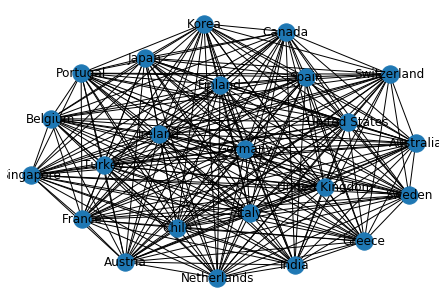

In [19]:
nx.draw_spring(G, with_labels = True)

Now we will add weigthed edges in the graphical representation. 

(-1.0413172164518727,
 1.0684760553839034,
 -1.0674867802651902,
 1.112360028187682)

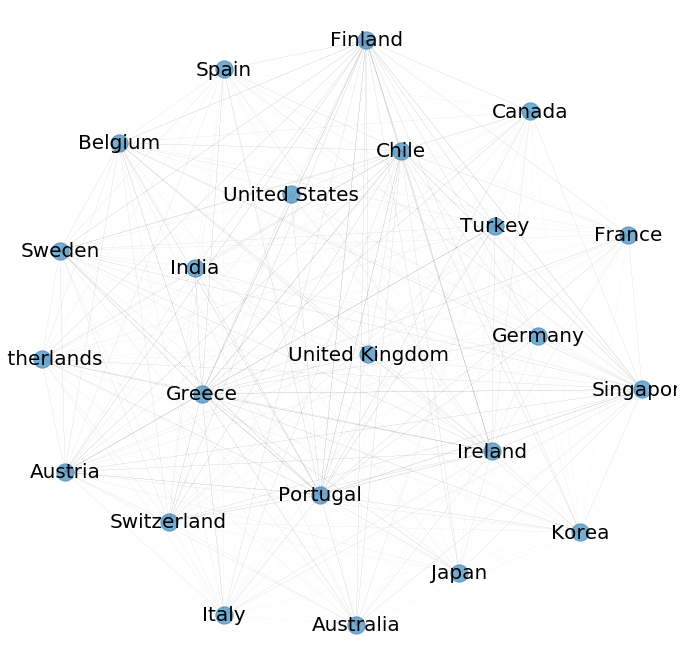

In [20]:
pos = nx.spring_layout(G)

# rendering
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G, pos, alpha = 0.6)
nx.draw_networkx_edges(G, pos, width=edgewidth)
nx.draw_networkx_labels(G,pos, font_size=20)
#nx.draw_networkx_labels(G, pos, labels)
plt.axis('off')
#visualize(G)

## Fixed Parameters <a name="fix"></a>

We will first inspect the spreading dynamics within a homogeneous population, hence using average betas and gammas for all countries. Plus, we will simulate an initial population of infected countries equal to 3.

0.12252048294549868
doing simulation
done with simulation, now plotting


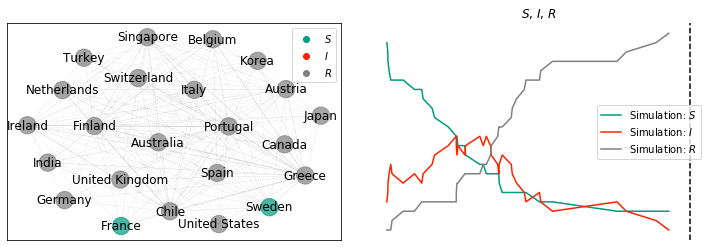

In [22]:
"""
Experiment 1: using average betas and gammas, without introducing heterogeneity and with 3 initially infected countries
"""
import EoN

gamma = np.average(gammas)   
beta = np.average(betas) 
r_0 = beta/gamma
print(r_0)
N = 23 # population size
I0 = 3   # intial n° of infected countries 
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = beta, gamma=gamma, rho = I0/N, return_full_data=True) 
print("done with simulation, now plotting")

sim.display(ts_plots=['SIR'], time = 10,  **nx_kwargs) #time at which the snapshot is taken
plt.axis('off') 
plt.draw()


## Fixed Parameters with Inverse Scores<a name="fixweight"></a>

Now let's introduce the inverse score to weight our betas.

10.792387620907112
doing simulation
done with simulation, now plotting


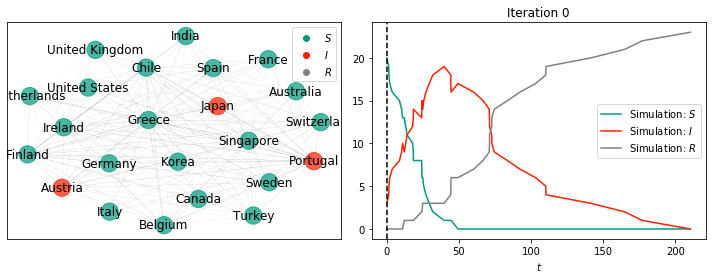

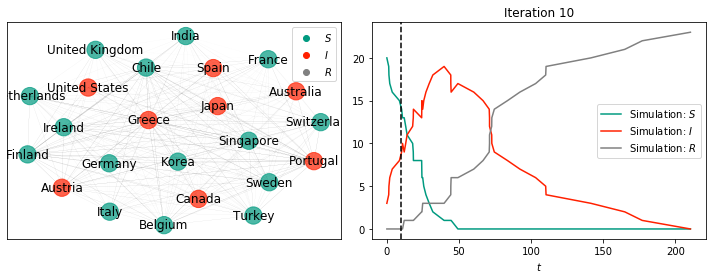

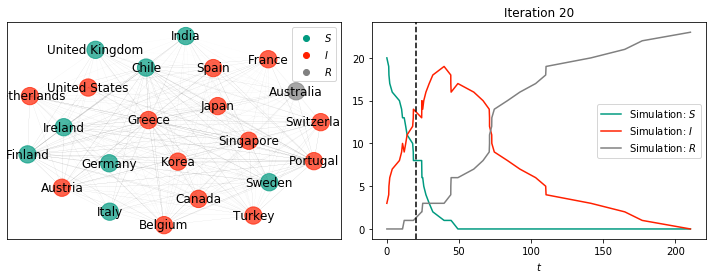

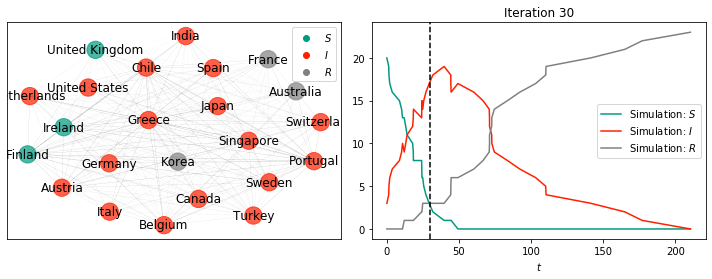

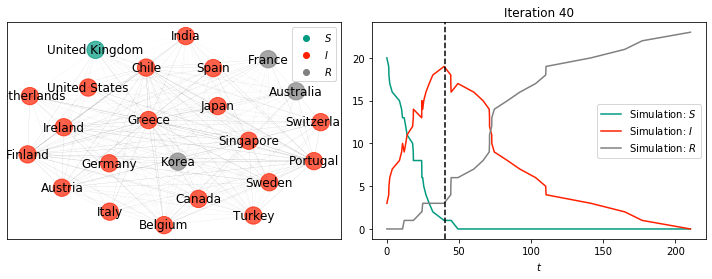

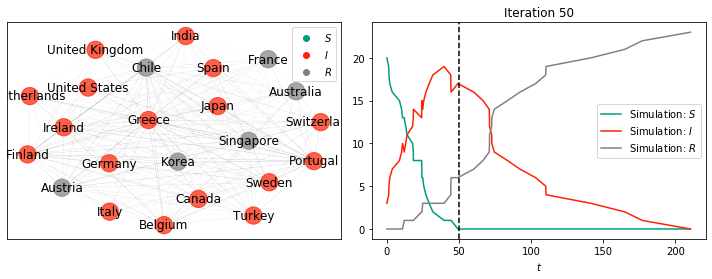

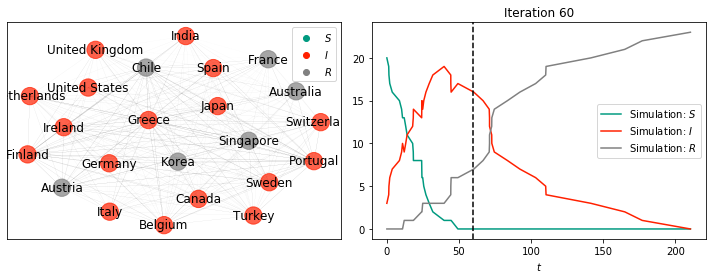

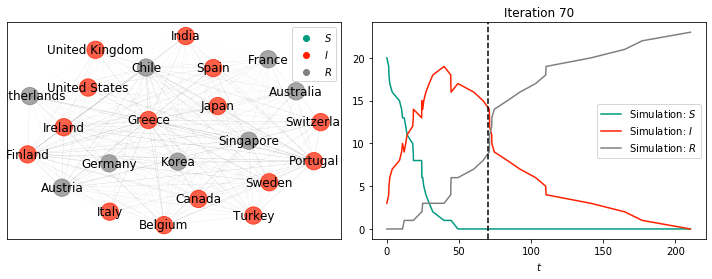

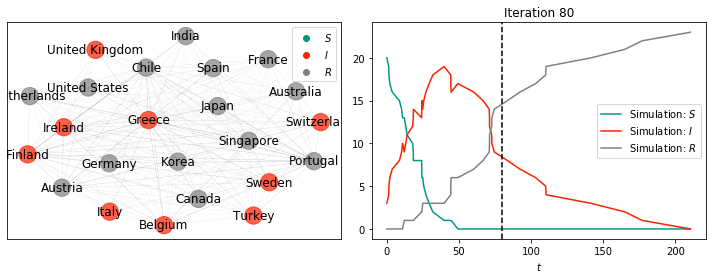

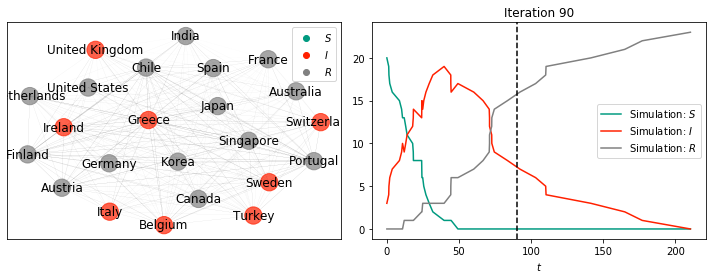

In [32]:
"""
Experiment 2: fixed parameters with weights inversely proportional to GDP

"""
gamma = np.min(gammas)   
beta = np.max(betas) 
r_0 = beta/gamma
print(r_0)
N = 23 # population size
I0 = 3   # intial n° of infected countries 
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = beta, gamma=gamma, rho = I0/N, transmission_weight="weights", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")

for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

  



## Introducing Heterogeneity <a name="heterogeneity"></a>

Now we are going to use betas and gammas themselves as weights, while the fixed parameters tau and gamma will be initialized to 1, resulting in each edge and node having individual parameters. Indeed, if we read the documentation of EoN, we can see that the attributes **transmission_weights** and **recovery_weights** are described as follows:

**transmission_weight**    string  (default None)
    the label for a weight given to the edges.
    transmission rate is
    G.adj[i][j][transmission_weight]*tau

**recovery_weight**   string (default None))
    a label for a weight given to the nodes to scale their 
    recovery rates
    gamma_i = G.node[i][recovery_weight]*gamma
    


doing simulation
done with simulation, now plotting


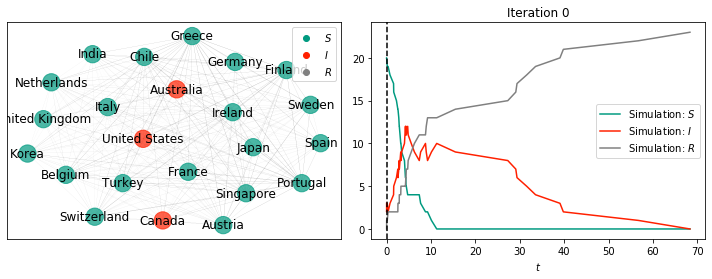

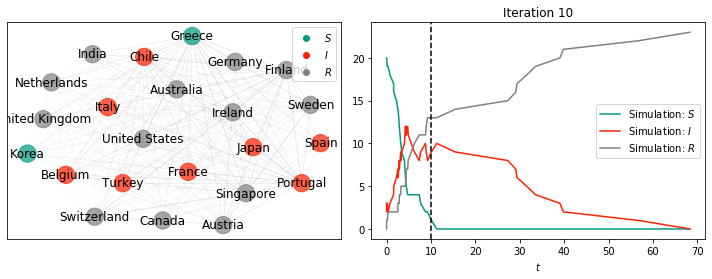

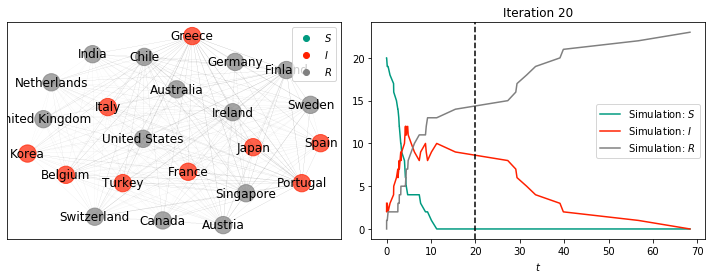

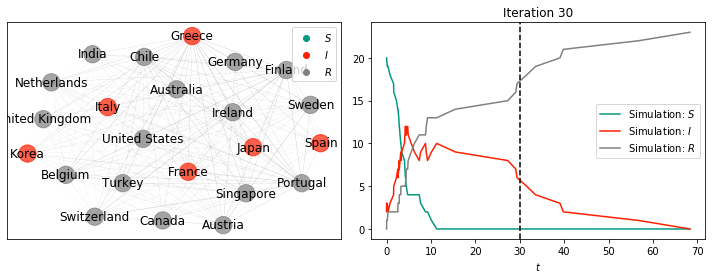

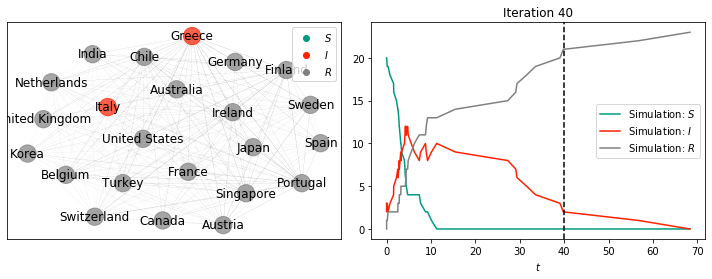

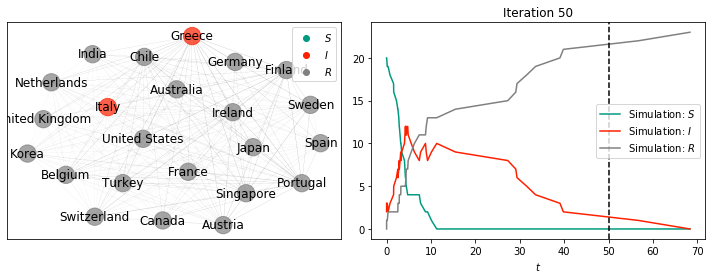

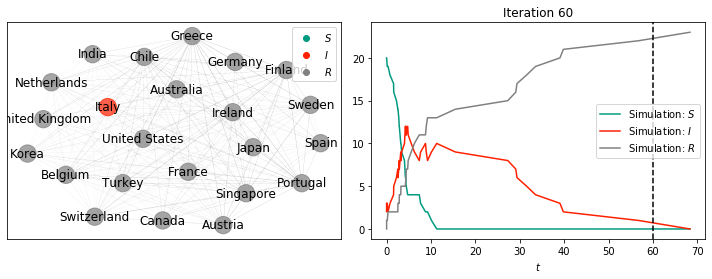

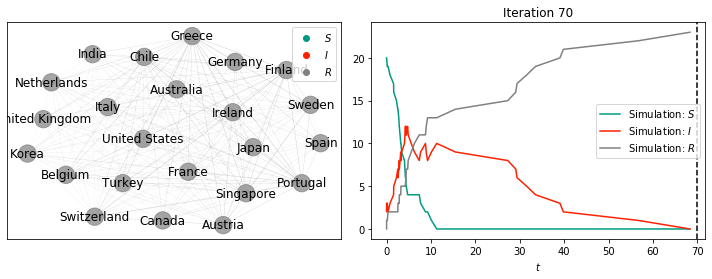

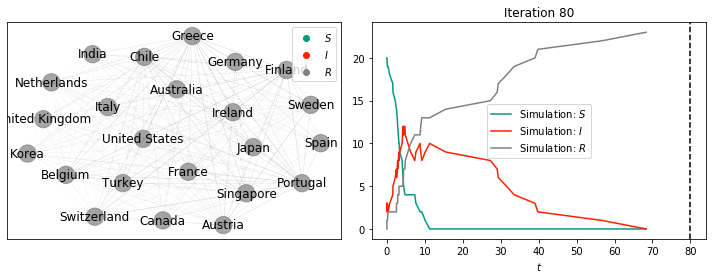

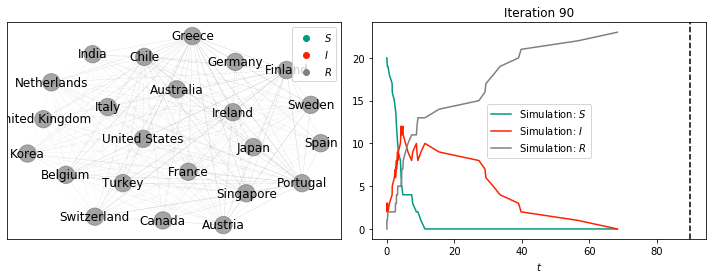

In [33]:
# we first need to attribute two further features to our edges: betas and gammas

betas_nx=np.zeros(23**2).reshape(23, 23)
for i in range(len(final_df)):
    for j in range(i+1, len(final_df)):
        if i!=j:
            betas_nx[i][j]=((final_df['betas'][i]+final_df['betas'][j])/2)

G = nx.Graph()
for i in range(len(countries)):
    G.add_node(countries[i], gammas_nx = final_df['gammas'][i])
    

for i in range(len(countries)):
    for j in range(i+1, len(countries)):
        G.add_edge(countries[i], countries[j], betas_nx=betas_nx[i][j])
   



#nx.write_gpickle(G, "G_caseB")
#G = nx.read_gpickle("G_caseB")

"""
Experiment 3: using betas and gammas as weights

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # intial n° of infected individuals 
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, rho = I0/N, recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   





## D. All Countries <a name="all"></a>

Now we are going to simulate the disease spreading for each starting country, using individual betas and gammas as computed in the section above.

**Note**: for sizing reasons, we removed the output of countries but U.S.A.

In [ ]:
"""
Australia

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries  
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'Australia', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from Australia') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
Austria

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries 
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'Austria', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from Austria') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
Belgium

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries 
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'Belgium', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from Belgium') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
Canada

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries  
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'Canada', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from Canada') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
Chile

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries 
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'Chile', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from Chile') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
Finland

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries 
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'Finland', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from Finland') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
France

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries 
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'France', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from France') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
Germany

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries 
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'Germany', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from Germany') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
Greece

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries 
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'Greece', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from Greece') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
India

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries 
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'India', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from India') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
Ireland

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries 
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'Ireland', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from Ireland') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
Italy

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'Italy', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from Italy') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
Japan

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'Japan', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from Japan') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
Korea

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries 
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'Korea', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from Korea') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
Netherlands

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries 
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'Netherlands', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from Netherlands') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
Portugal

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'Portugal', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from Portugal') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
Singapore

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'Singapore', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from Singapore') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
Spain

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'Spain', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta 
print("done with simulation, now plotting")


print('Crisis starts from Spain') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
Sweden

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries 
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'Sweden', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from Sweden') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
Switzerland

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries 
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'Switzerland', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from Switzerland') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
Turkey

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries 
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'Turkey', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from Turkey') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



In [ ]:
"""
United Kingdom

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries 
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'United Kingdom', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta
print("done with simulation, now plotting")


print('Crisis starts from United Kingdom') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   



doing simulation
done with simulation, now plotting
Crisis starts from United States


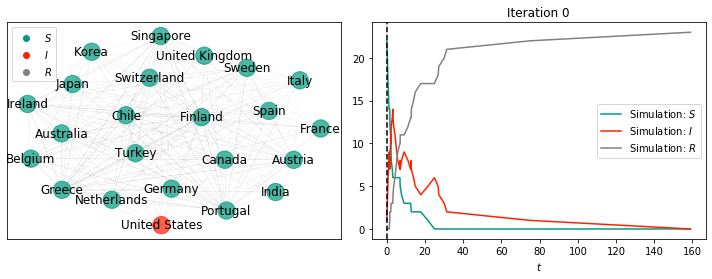

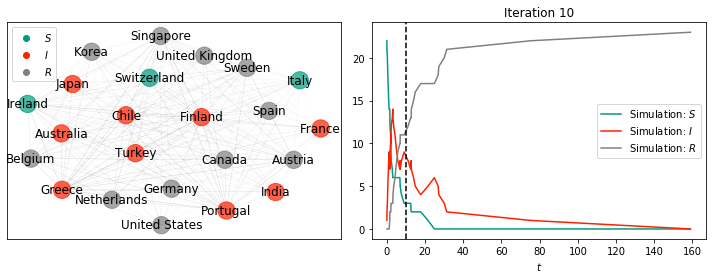

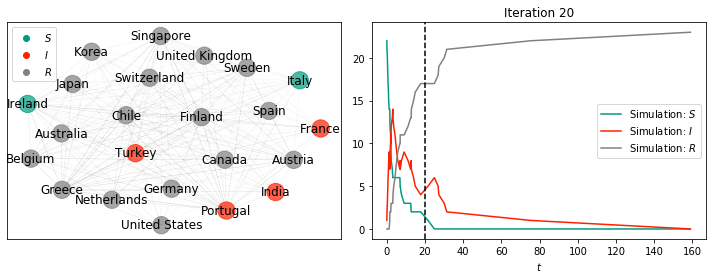

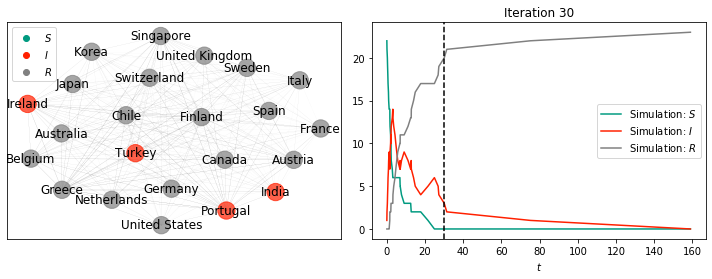

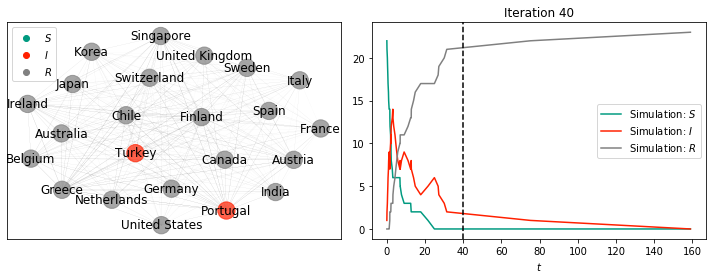

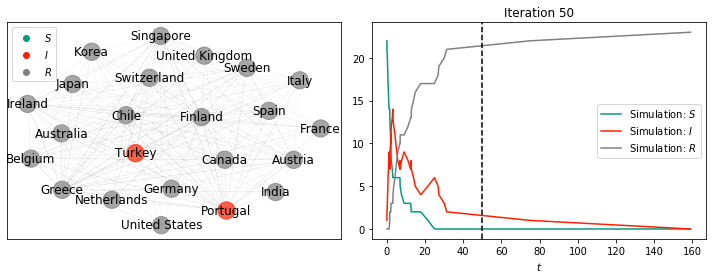

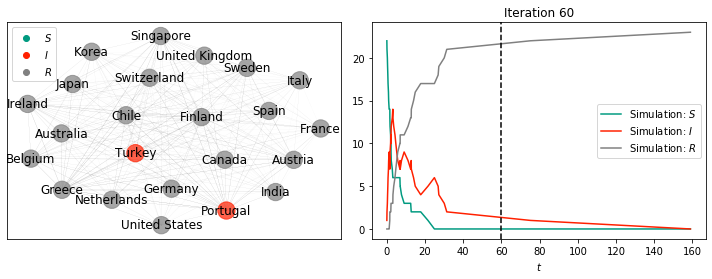

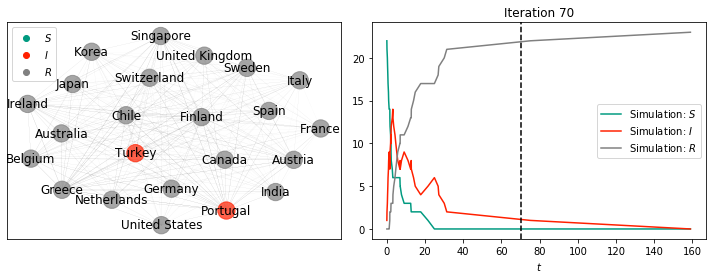

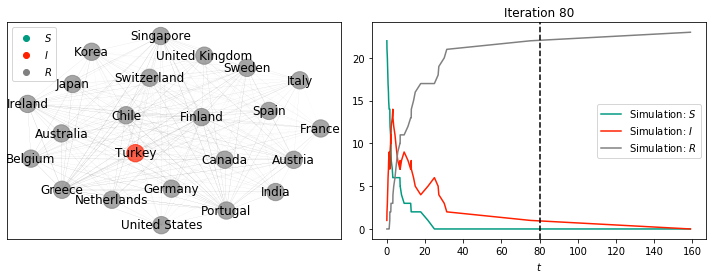

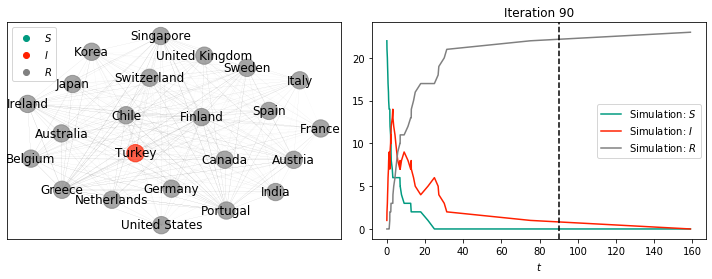

In [55]:
"""
United States

"""
#gamma = np.average(gammas)   
#beta = np.min(betas) 
#r_0 = beta/gamma
#print(r_0)
N = 23 # population size
I0 = 3   # initial n° of infected countries 
R0 = 0
S0 = N - I0 -R0

pos = nx.spring_layout(G)

nx_kwargs = {"with_labels":True, "pos": pos, "width": edgewidth, "alpha": 0.7} #optional arguments to be passed on to the
#networkx plotting command.



print("doing simulation")
sim = EoN.fast_SIR(G, tau = 1, gamma=1, initial_infecteds = 'United States', recovery_weight="gammas_nx", transmission_weight="betas_nx", return_full_data=True) #here tau stands for beta 
print("done with simulation, now plotting")


print('Crisis starts from United States') 
for i in range(0,100, 10):
    sim.display(ts_plots=['SIR'], time = i,  **nx_kwargs) 
    plt.title("Iteration {}".format(i))
    plt.draw()

   

